# Melanoma Detection using CNN

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [85]:
#! pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

2.17.1
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import pathlib
#import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive (for Google Colab environment)
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import zipfile
import os

# Specify the path to the zip file and the target directory
zip_file_path = '/content/drive/MyDrive/CNN_assignment.zip'
extract_to_directory = '/content/drive/MyDrive/'

# Check if the file exists
if os.path.exists(zip_file_path):
    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_directory)
    print(f"File extracted to {extract_to_directory}")
else:
    print(f"The file {zip_file_path} does not exist.")

File extracted to /content/drive/MyDrive/


In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

# Check if the directories exist
if data_dir_train.exists() and data_dir_test.exists():
    print("Directories exist")
else:
    print("One or both directories do not exist")


Directories exist


Count no of files/ images available in train and test data

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


##Load Train data using Keras Preprocessing


### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:

#  Read the Training dataset
#  tf.keras.preprocessing.image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#  label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

train_ds  = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                batch_size=batch_size,
                                                                image_size=(img_height, img_width),
                                                                seed=123,
                                                                label_mode='categorical',
                                                                subset="training",
                                                                validation_split=0.2
                                                                )



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
# Validation dataset
# tf.keras.preprocessing.image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
# label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

val_ds  = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              batch_size=batch_size,
                                                              image_size=(img_height, img_width),
                                                              seed=123,
                                                              label_mode='categorical',
                                                              subset="validation",
                                                              validation_split=0.2
                                                              )


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Store all the classes of skin cancer in a list.

class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

<Figure size 1500x2000 with 0 Axes>

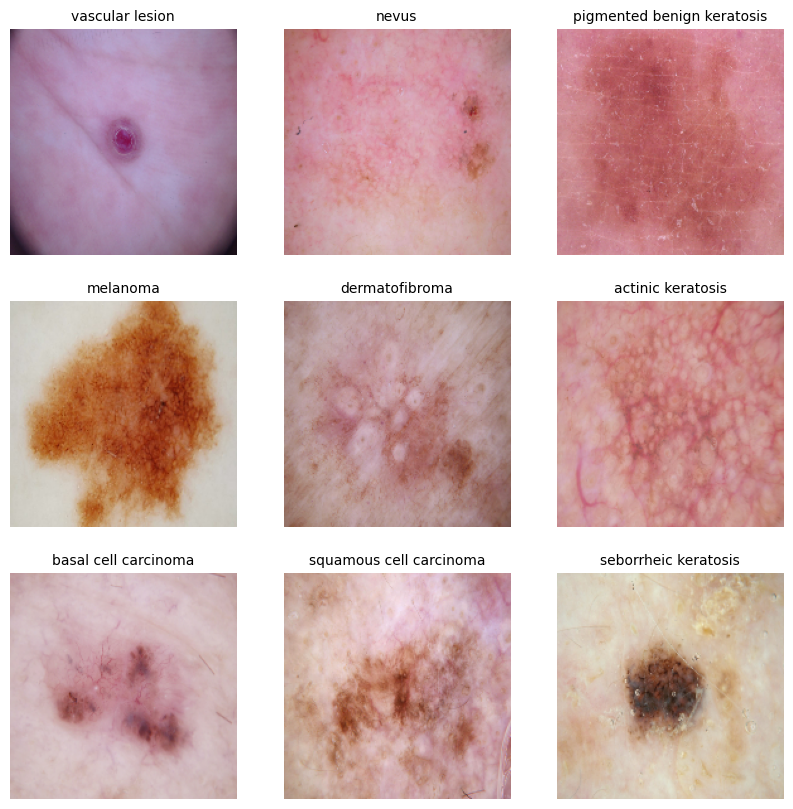

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store whether we have shown an image for a class
class_displayed = {class_name: False for class_name in train_ds.class_names}

plt.figure(figsize=(15,20))
index = 0

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()  # Flatten axes array for easy indexing

# Initialize an empty DataFrame for the class distribution
train_data_df = pd.DataFrame(columns=['Class', 'No. of Image'])

class_count=0
for image, label in train_ds:
    # Convert the label tensor to numpy
    label = label.numpy()  # This gives you a numpy array of labels for the batch

    for i in range(len(label)):  # Loop over each label in the batch
        class_index =np.argmax(label[i])
        class_name = train_ds.class_names[class_index]  # Get class name by using label[i]

        # Check if we've already displayed an image for this class
        if not class_displayed[class_name]:
            # Display the first image for this class
            axes[index].imshow(image[i].numpy().astype("uint8"))  # Convert to numpy for displaying
            axes[index].set_title(class_name, fontsize=10)  # Display the class name as the title
            axes[index].axis('off')  # Hide the axes for a cleaner look

            # Mark this class as displayed
            class_displayed[class_name] = True
            index+=1

    # Check if we've displayed an image for all classes, and break the loop if true
    if all(class_displayed.values()):
        break





## Getting Information of amount of data available for each class

In [ ]:
import os

# images are organized into folders by class
base_path = data_dir_train  # Replace with your dataset path
classes = os.listdir(data_dir_train)  # This will list class names if folder structure is used

# Initialize an empty DataFrame for the class information
train_data_df = pd.DataFrame(columns=['Class', 'Number_of_Images'])


# Count the number of images per class
for class_name in classes:
    # getting the directory path for class
    class_path = os.path.join(data_dir_train, class_name)

    # if directory with class name exists, read the no of files in that directory and add class name, no of files into a dataframe
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        train_data_df.loc[len(train_data_df)] = [class_name, class_count]

# Print the dataframe details with class name and no of images for each class
print(train_data_df)

                        Class  Number_of_Images
0           actinic keratosis               114
1        basal cell carcinoma               376
2              dermatofibroma                95
3                    melanoma               438
4                       nevus               357
5  pigmented benign keratosis               462
6        seborrheic keratosis                77
7     squamous cell carcinoma               181
8             vascular lesion               139


## Visualising the distribution of Training dataset

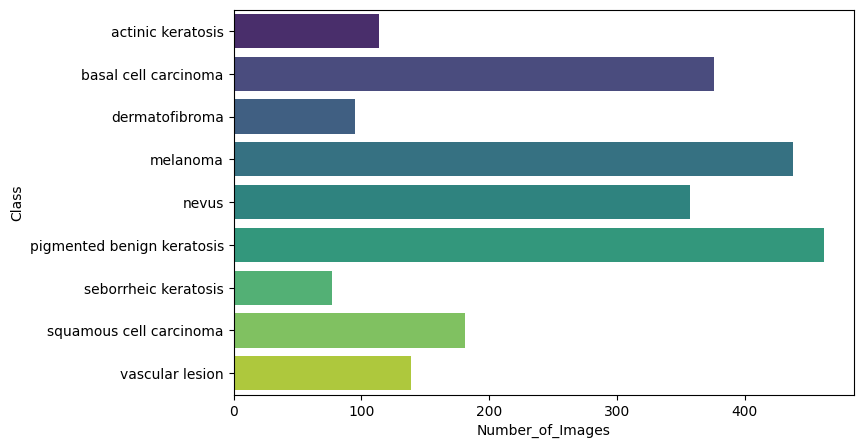

In [ ]:
#Plotting the Number of images in each class.
import seaborn as sns
plt.figure(figsize=(8,5))
sns.barplot(x="Number_of_Images", y="Class",
            data=train_data_df,
            palette="viridis",
            label="Class")
plt.show()

Findings :

a) 'seborrheic keratosis' class has the least number of samples (77)

b) 'pigmented benign keratosis' classes has the most number of samples (462)

There is clear class imbalance in this data which can impact performance of the model

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build the model - model1


In [ ]:
#CNN Model Architecture

#from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Number of target labels are 9
target_labels = 9

#Sequential model allows to create models layer-by-layer
model_1 = Sequential([
  #Rescaling Layer
  keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #First Convulation layer
  layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Second Convulation Layer
  layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Third Convulation Layer
  layers.Conv2D(128,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Dropout layer with 50% Fraction of the input units to drop
  layers.Dropout(0.5),
  #Flatten Layer
  layers.Flatten(),
  #Dense Layer
  layers.Dense(128, activation='relu'),
  #Dropout layer with 25% Fraction of the input units to drop
  layers.Dropout(0.25),
  #Dense Layer with softmax activation function
  layers.Dense(target_labels,activation='softmax')

])

# View the summary of all layers
model_1.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Visualising the model

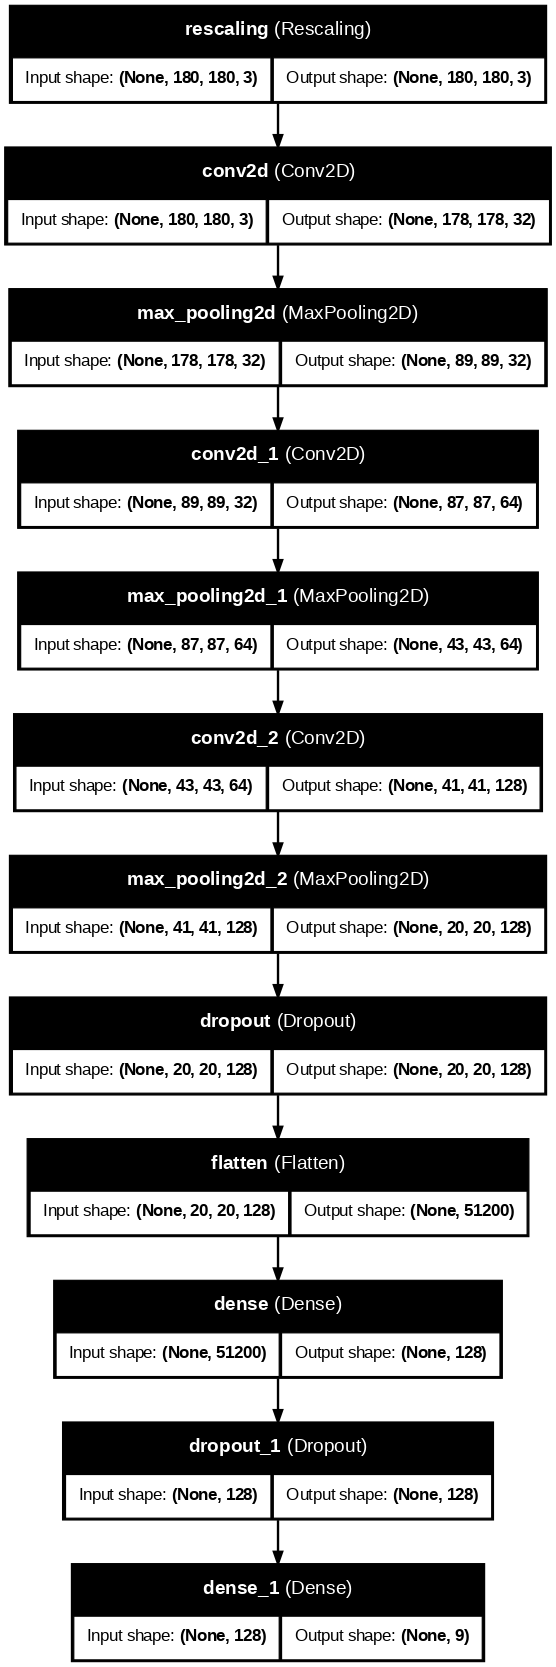

In [ ]:
# vizualising the model
from tensorflow.keras.utils import plot_model
plot_model(
    model_1,
    to_file='model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=85
    )

Compile the model


In [ ]:
### Compiling model with optimiser 'adam' and loss function 'SparseCategoricalCrossentropy' for model training

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


In [ ]:
for data, labels in train_ds.take(1):
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)

Data shape: (32, 180, 180, 3)
Labels shape: (32, 9)


Training the model

In [ ]:

%%time
epochs = 20
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.2052 - loss: 2.2608 - val_accuracy: 0.3244 - val_loss: 1.8857
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.3025 - loss: 1.9113 - val_accuracy: 0.3289 - val_loss: 1.7796
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3839 - loss: 1.6944 - val_accuracy: 0.4564 - val_loss: 1.5589
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4492 - loss: 1.5430 - val_accuracy: 0.5391 - val_loss: 1.4207
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5036 - loss: 1.4676 - val_accuracy: 0.4653 - val_loss: 1.4675
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4978 - loss: 1.4593 - val_accuracy: 0.4251 - val_loss: 1.6699
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4783 - loss: 1.4745 - val_accuracy: 0.5213 - val_loss: 1.3587
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5475 - loss: 1.3185 - val_accuracy: 0.5324 -

Visualizing results - accuracy plots, loss plots
(training vs validation)

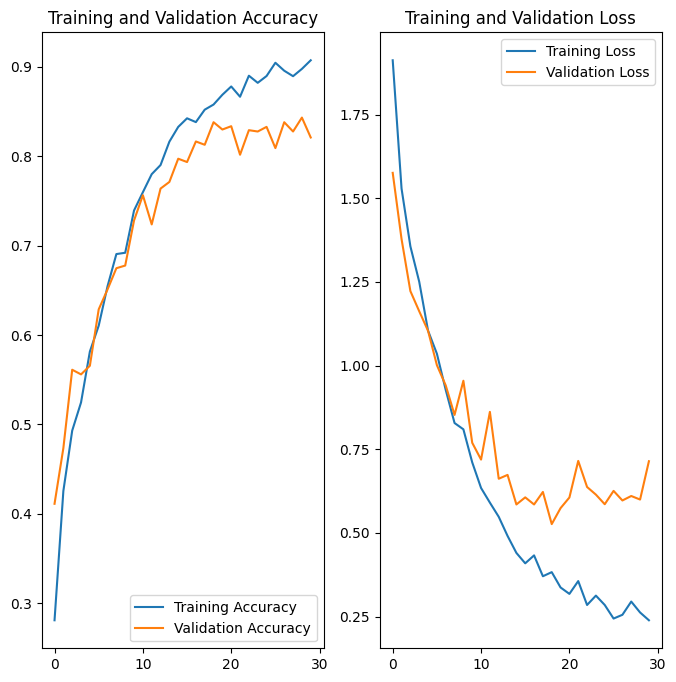

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings:

The above Model is overfitting. From the Training vs Validation accuracy plot, it is seen that as epochs increases the difference between Training accuracy and validation accuracy increases.

In [ ]:
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range
  keras.layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential(
  [

    # Flip horizontal
    layers.RandomFlip("horizontal",  input_shape=(img_height,img_width,3)),
    # rotation
    layers.RandomRotation(0.1),
    # Zoom
    layers.RandomZoom(0.1),
    # translate
    layers.RandomTranslation(0.1, 0.1)
  ]
)



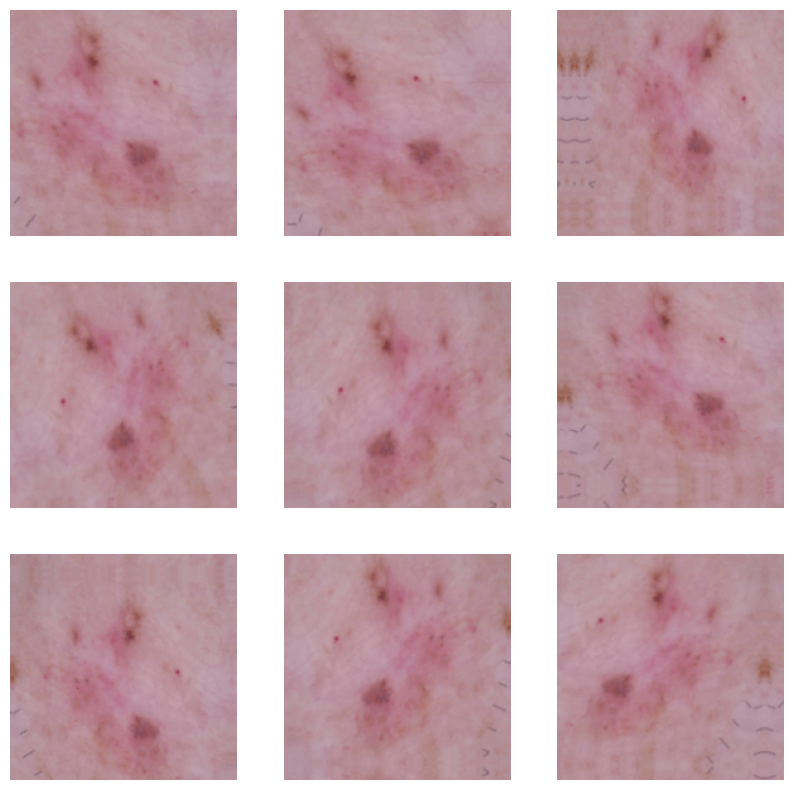

In [ ]:
# Visualize how the augmentation strategy works for one instance of training image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        # Apply data augmentation to images in class
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# The augmented_images now contain the original images with applied transformations.




Build the model - model2


In [ ]:
## Model 2 Creation

#Dropout layer: randomly sets input units to 0 with a frequency of rate at each step during training time,
#which helps prevent overfitting.Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

# Number of target labels are 9
target_labels = 9

model_2 = tf.keras.Sequential([data_augmentation,
                              rescale,
                              layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
                              layers.MaxPool2D(pool_size=(2,2)),
                              layers.Dropout(0.25),
                              layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
                              layers.MaxPool2D(pool_size=(2,2)),
                              layers.Dropout(0.25),
                              layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
                              layers.MaxPool2D(pool_size=(2,2)),
                              layers.Flatten(),
                              layers.Dense(512, activation='relu'),
                              layers.Dense(128, activation='relu'),
                              layers.Dropout(0.50),
                              layers.Dense(target_labels, activation='softmax')])



# View the summary of all layers
model_2.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,374,985 (100.61 MB)

 Trainable params: 26,374,985 (100.61 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the model

In [ ]:
model_2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs

%%time
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1692 - loss: 2.8555 - val_accuracy: 0.2707 - val_loss: 2.0575
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.2717 - loss: 1.9611 - val_accuracy: 0.3266 - val_loss: 1.8719
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3425 - loss: 1.8530 - val_accuracy: 0.3870 - val_loss: 1.7119
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4012 - loss: 1.7051 - val_accuracy: 0.4743 - val_loss: 1.5591
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4329 - loss: 1.6291 - val_accuracy: 0.4765 - val_loss: 1.5471
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4406 - loss: 1.5909 - val_accuracy: 0.5078 - val_loss: 1.4800
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.4692 - loss: 1.4670 - val_accuracy: 0.4653 - val_loss: 1.5397
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4645 - loss: 1.5252 - val_accuracy: 0.5257 - v

Visualizing the results - accuracy plots , loss plots
(training vs validataion)

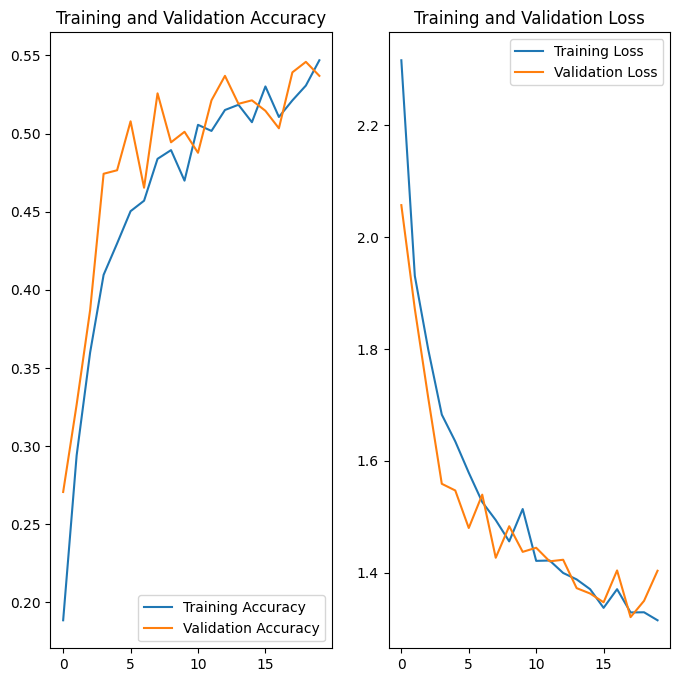

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Findings :

from the above graph, the problem of overfitting has reduce after using data augumentation and dropout layer.The accuracy of model is still not increased.

## Handling Class imbalance
Using python package `Augmentor` to add more samples in classes that have fewer samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:

path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5B3D3808B0>: 100%|██████████| 500/500 [00:25<00:00, 19.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5B04568AF0>: 100%|██████████| 500/500 [00:21<00:00, 22.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5B1CA78E20>: 100%|██████████| 500/500 [00:24<00:00, 20.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D5B8F75DB40>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5B33DBFF70>: 100%|██████████| 500/500 [01:34<00:00,  5.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5B1CACED70>: 100%|██████████| 500/500 [00:23<00:00, 21.15 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D5B309334C0>: 100%|██████████| 500/500 [00:47<00:00, 10.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D5B045A8C70>: 100%|██████████| 500/500 [00:20<00:00, 24.62 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5B00477310>: 100%|██████████| 500/500 [00:21<00:00, 23.30 Samples/s]





Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list



['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_2fb08b69-0191-4ab2-9817-363c7ecb0144.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_ead6f491-446c-4bb5-af23-93aaa86e15b2.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_a0b2ec51-b38b-4618-9d05-26662bcd40cf.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032135.jpg_0e32f65d-fdae-4cb7-ad35-ab9644fa22fa.jpg',
 '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_8d113ad2-1d2e-47a9

In [ ]:
class_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#class_list_new


In [ ]:
dataframe_dict_new = dict(zip(path_list, class_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [ ]:
df2['Label'].value_counts()

,count
Label,
actinic keratosis,500
basal cell carcinoma,500
dermatofibroma,500
melanoma,500
nevus,500
pigmented benign keratosis,500
seborrheic keratosis,500
squamous cell carcinoma,500
vascular lesion,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Read Training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Read validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Build the model - Model3

In [ ]:
target_labels = 9

model_3= Sequential([
  #Rescaling Layer
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #First Convulation layer
  layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Second Convulation Layer
  layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Third Convulation Layer
  layers.Conv2D(128,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Dropout layer with 50% Fraction of the input units to drop
  layers.Dropout(0.5),
  #Flatten Layer
  layers.Flatten(),
  #Dense Layer
  layers.Dense(128, activation='relu'),
  #Dropout layer with 25% Fraction of the input units to drop
  layers.Dropout(0.25),
  #Batch normalization makes CNNs faster and more stable through normalization of layers' inputs by re-centering and re-scaling.
  layers.BatchNormalization(),
  #Dense Layer with softmax activation function
  layers.Dense(target_labels,activation='softmax')

])

Compile the model

In [ ]:
model_3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Train the model

In [ ]:
%%time
epochs = 30

history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)



Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 284ms/step - accuracy: 0.1826 - loss: 2.3563 - val_accuracy: 0.2732 - val_loss: 2.0239
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 252ms/step - accuracy: 0.3528 - loss: 1.7170 - val_accuracy: 0.3304 - val_loss: 1.8493
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.4316 - loss: 1.4812 - val_accuracy: 0.4425 - val_loss: 1.4931
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 48s 284ms/step - accuracy: 0.4896 - loss: 1.3626 - val_accuracy: 0.4610 - val_loss: 1.3769
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 237ms/step - accuracy: 0.5025 - loss: 1.3266 - val_accuracy: 0.5353 - val_loss: 1.2455
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.5212 - loss: 1.2595 - val_accuracy: 0.5375 - val_loss: 1.2562
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 241ms/step - accuracy: 0.4922 - loss: 1.3762 - val_accuracy: 0.5449 - val_loss: 1.2099
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 240ms/step - accuracy: 0.5484 - loss: 1

Visualizing the results - accuracy plots , loss plots
(training vs validataion)

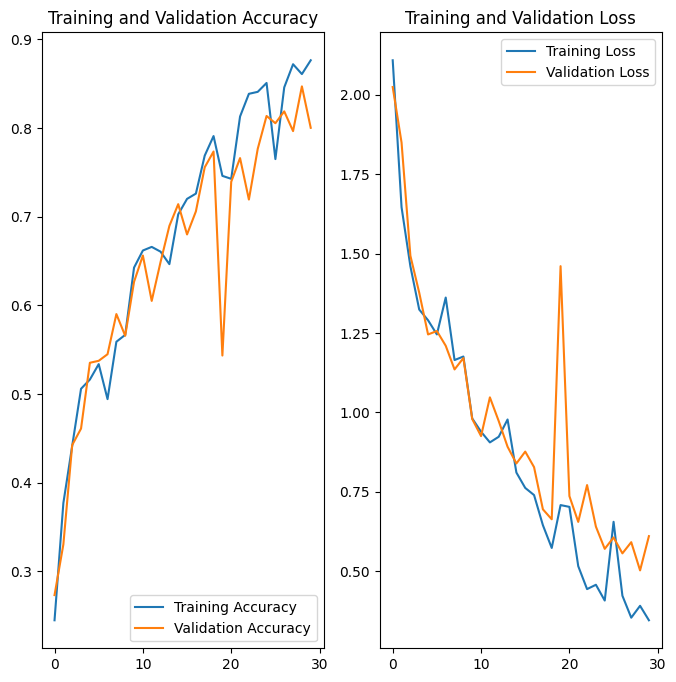

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings :
The training accuracy and validation accuracy are close. This is a sign of good fit.
The training loss and validation loss are almost same. This is a sign of good fit.
The Validation accuracy is 0.87 which is good. The model is able to classify the images with 87 % accu



### Build model without batch normalisation

Build model -model4

In [ ]:
target_labels = 9

model_4= Sequential([
  #Rescaling Layer
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  #First Convulation layer
  layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Second Convulation Layer
  layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Third Convulation Layer
  layers.Conv2D(128,kernel_size=(3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #Dropout layer with 50% Fraction of the input units to drop
  layers.Dropout(0.5),
  #Flatten Layer
  layers.Flatten(),
  #Dense Layer
  layers.Dense(128, activation='relu'),
  #Dropout layer with 25% Fraction of the input units to drop
  layers.Dropout(0.25),

  #Dense Layer with softmax activation function
  layers.Dense(target_labels,activation='softmax')

])

Complie the model

In [ ]:
model_4.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Train the model

In [ ]:
%%time
epochs = 30

history = model_4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 255ms/step - accuracy: 0.1985 - loss: 2.1251 - val_accuracy: 0.4113 - val_loss: 1.5760
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 252ms/step - accuracy: 0.4136 - loss: 1.5541 - val_accuracy: 0.4736 - val_loss: 1.3781
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.4865 - loss: 1.3798 - val_accuracy: 0.5612 - val_loss: 1.2227
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.5046 - loss: 1.3014 - val_accuracy: 0.5561 - val_loss: 1.1624
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.5708 - loss: 1.1309 - val_accuracy: 0.5657 - val_loss: 1.1039
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 246ms/step - accuracy: 0.5759 - loss: 1.1118 - val_accuracy: 0.6288 - val_loss: 1.0015
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 243ms/step - accuracy: 0.6390 - loss: 0.9602 - val_accuracy: 0.6511 - val_loss: 0.9408
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.6839 - loss: 0

Visualizing the results - accuracy plots , loss plots
(training vs validataion)

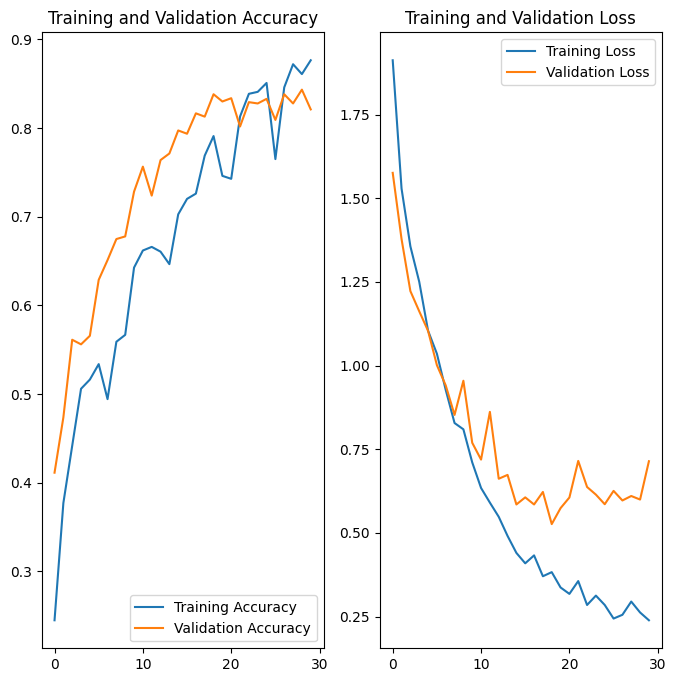

In [ ]:
cc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Findings :
The training accuracy and validation accuracy are close. This is a sign of good fit.
The training loss and validation loss are almost same. This is a sign of good fit.
The Validation accuracy is 0.90 which is good. The model is able to classify the images with 90 % accuracy.

### Model Evaluation on Test Data - on one instance of a class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


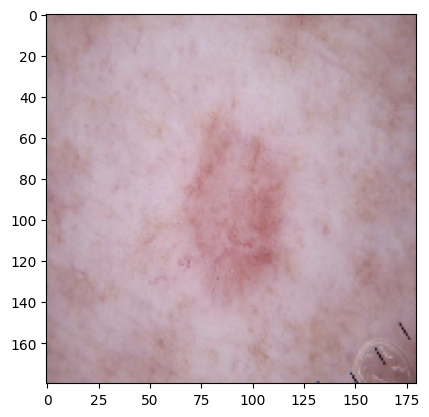

In [ ]:
from tensorflow.keras.preprocessing.image import load_img

test_image_path = os.path.join(data_dir_test, class_names[2], '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model_4.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)


